In [1]:
import datetime
from matplotlib import pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd
import plotly.express as px
import json
import time

In [2]:
def readScatterData(path):
    """ 读取所有外部存档的目标值
    """
    TotalDelay = []
    Utilization = []

    with open(path) as f:
        for line in f.readlines():
            datas = json.loads(line)
            for data in datas:
                if datas[data][0] not in TotalDelay:
                    TotalDelay.append(datas[data][0])
                if datas[data][1] not in Utilization:
                    Utilization.append(datas[data][1])

    # TotalDelay = []
    # Utilization = []

    # for map in data:
    #     TotalDelay.append(data[map][0])
    #     Utilization.append(data[map][1])

    return TotalDelay, Utilization


In [3]:
def readAllScatterData(path):
    """ 读取所有外部存档的目标值
    """

    TotalDelay = []
    Utilization = []

    with open(path) as f:
        for line in f.readlines():
            datas = json.loads(line)
            for data in datas:
                TotalDelay.append(datas[data][0])
                Utilization.append(datas[data][1])
    # for map in data:
    #     TotalDelay.append(data[map][0])
    #     Utilization.append(data[map][1])

    return TotalDelay, Utilization

In [4]:
def readtimetable(timetable):

    """记录编码"""
    code = timetable.get("code")
    ConfigurationCode = code.get("ConfigurationCode")
    OperationCode = code.get("OperationCode")
    SortCode = code.get("SortCode")
    """记录解码"""
    decode = timetable.get("decode")
    StartTime = decode.get("StartTime")
    FinishTime = decode.get("FinishTime")
    ProcessingTime = decode.get("ProcessingTime")
    SetupStartTime = decode.get("SetupStartTime")
    SetupFinishTime = decode.get("SetupFinishTime")
    
    """记录结果指标"""
    Makespan = decode.get("Makespan")
    TotalDelay = decode.get("TotalDelay")
    Utilization = decode.get("Utilization")
    R = timetable.get("R")

    return StartTime, FinishTime, ProcessingTime, SetupStartTime, SetupFinishTime, ConfigurationCode, SortCode, TotalDelay, Utilization


"""甘特图绘制，输入：
时间表：[{OP1:[T1,T2,T3...], OP2:[T4,T5...]},{...}]
解：{"ConfigurationCode":[1,3,5,2,4,7,6],"OperationCode":{"1":{"1":1,"2":2,"5":4,"6":5,"7":6,"8":6,"9":6},"2":{"1":1,"2":2,"3":2,"5":4,"6":5,"7":6,"8":6,"9":6},"3":{"2":5,"7":7,"8":7,"9":7},"4":{"2":2,"3":2,"4":4,"7":6,"8":6,"9":6},"5":{"2":3,"9":6}},"SortCode":[3,1,4,5,2]}
title：甘特图名
"""
def DrawGantt(S_table, F_table, Setup_S, Setup_F, ConfigurationCode, SortCode, title):

    struct_time = (2022, 4, 1, 8, 0, 0, 1, 152, 0)    # 2022.04.01 8:00:00开始
    start_time = time.mktime(struct_time)

    task = []                               # 记录工件种类
    start = []                              # 记录工件开始时间
    finish = []                             # 记录工件结束时间
    Resource = []                           # 记录工件所在机器
    text = []                               # 记录注释

    PartName = ["001-00536","02JH585","100-02653","KF17A38386","KF17A38396","KF17A38988","KF17A38989","KF17A40120","100-04729-G","100-04731-G","100-04738-G","100-04739-G","100-04740-G","100-04743-G","100-04753-G","100-04770-G","108-00855-G","100-04583-G","100-04585","100-04587","100-04588","100-04590","100-04591","100-04592","100-04593","100-04594","100-04595","100-04630","100-04830","WB00062-00","WB56038-00","WB80120-00","WB80121-00"]

    for machineindex in range(len(ConfigurationCode)):  # 机器序号
        machine = ConfigurationCode[machineindex]
        for OP in S_table[machineindex]:                # 该机器上的操作
            for partindex in range(len(SortCode)):      # 工件序号
                Resource.append("RMT" + str(machine) + "-OP" + str(OP))
                # duration.append(Processing[machineindex].get(OP).get(partindex))
                task.append('P' + str(SortCode[partindex]))
                text.append(str(SortCode[partindex]))
                # task.append(PartName[partindex])
                start.append(datetime.datetime.fromtimestamp(S_table[machineindex].get(OP)[partindex]*60 + start_time).isoformat())
                finish.append(datetime.datetime.fromtimestamp(F_table[machineindex].get(OP)[partindex]*60 + start_time).isoformat())
    for machineindex in range(len(ConfigurationCode)):                  # 机器序号
        machine = ConfigurationCode[machineindex]
        for OP in Setup_S[machineindex]:                            # 该机器上的操作
            for index in range(len(Setup_S[machineindex].get(OP))): # 工件序号
                Resource.append("RMT" + str(machine) + "-OP" + str(OP))
                task.append('换模')
                text.append('')
                start.append(datetime.datetime.fromtimestamp(Setup_S[machineindex].get(OP)[index]*60 + start_time).isoformat())
                finish.append(datetime.datetime.fromtimestamp(Setup_F[machineindex].get(OP)[index]*60 + start_time).isoformat())

    df = pd.DataFrame(data=Resource, columns=['Machine'])
    df['Start'] = start
    df['Finish'] = finish
    df['Task'] = task
    df['Text'] = text

    # print(df)

    return px.timeline(
        data_frame=df,
        x_start="Start",
        x_end="Finish",
        y="Machine",
        color="Task",
        text="Text",
        title=str(title),  
        # color_discrete_sequence=["white"], # 选择颜色
        color_discrete_sequence=[
            "#E57373","#F06292","#BA68C8","#9575CD","#7986CB","#64B5F6","#4FC3F7","#4DD0E1","#4DB6AC","#81C784","#AED581",
            "#DCE775","#FFF176","#FFD54F","#FFB74D","#FF8A65","#A1887F","#B71C1C","#880E4F","#4A148C","#311B92","#1A237E",
            "#0D47A1","#01579B","#006064","#004D40","#1B5E20","#33691E","#827717","#F57F17","#FF6F00","#E65100","#BF360C",
            "#90A4AE",
        ],
        color_discrete_map={"换模":"black"},
        # category_orders={"Task": ["D1", "D2", "D3", "D4"]}, # 标签排序
    )

'甘特图绘制，输入：\n时间表：[{OP1:[T1,T2,T3...], OP2:[T4,T5...]},{...}]\n解：{"ConfigurationCode":[1,3,5,2,4,7,6],"OperationCode":{"1":{"1":1,"2":2,"5":4,"6":5,"7":6,"8":6,"9":6},"2":{"1":1,"2":2,"3":2,"5":4,"6":5,"7":6,"8":6,"9":6},"3":{"2":5,"7":7,"8":7,"9":7},"4":{"2":2,"3":2,"4":4,"7":6,"8":6,"9":6},"5":{"2":3,"9":6}},"SortCode":[3,1,4,5,2]}\ntitle：甘特图名\n'

Text(0.5, 0, 'total delay/min')

Text(0, 0.5, 'average utilization/%')

Text(0.5, 1.0, 'Pareto Front Comparison')

NSGAII：	34个Pareto解
SPEA2：	19个Pareto解
MOEA：	21个Pareto解
C(SPEA2, NSGAII) = 0.264706,  C(NSGAII, SPEA2) = 0.578947; 
C(MOEA, NSGAII) = 0.352941,  C(NSGAII, MOEA) = 0.142857; 
HV(NSGAII) =	58255085.032221, 
HV(SPEA2) = 	58326895.280306, 
HV(MOEA) =	61443969.004880. 


Text(0.5, 0, 'total delay/min')

Text(0, 0.5, 'average utilization/%')

Text(0.5, 1.0, 'Pareto Front Comparison')

NSGAII：	31个Pareto解
SPEA2：	18个Pareto解
MOEA：	9个Pareto解
C(SPEA2, NSGAII) = 0.000000,  C(NSGAII, SPEA2) = 1.000000; 
C(MOEA, NSGAII) = 0.516129,  C(NSGAII, MOEA) = 0.222222; 
HV(NSGAII) =	58914379.184153, 
HV(SPEA2) = 	57174968.113276, 
HV(MOEA) =	61004740.847106. 


Text(0.5, 0, 'total delay/min')

Text(0, 0.5, 'average utilization/%')

Text(0.5, 1.0, 'Pareto Front Comparison')

NSGAII：	26个Pareto解
SPEA2：	16个Pareto解
MOEA：	21个Pareto解
C(SPEA2, NSGAII) = 0.692308,  C(NSGAII, SPEA2) = 0.187500; 
C(MOEA, NSGAII) = 0.269231,  C(NSGAII, MOEA) = 0.428571; 
HV(NSGAII) =	60156175.192616, 
HV(SPEA2) = 	58244848.645671, 
HV(MOEA) =	59408404.782164. 


Text(0.5, 0, 'total delay/min')

Text(0, 0.5, 'average utilization/%')

Text(0.5, 1.0, 'Pareto Front Comparison')

NSGAII：	31个Pareto解
SPEA2：	16个Pareto解
MOEA：	19个Pareto解
C(SPEA2, NSGAII) = 0.290323,  C(NSGAII, SPEA2) = 0.375000; 
C(MOEA, NSGAII) = 0.225806,  C(NSGAII, MOEA) = 0.157895; 
HV(NSGAII) =	60990876.678070, 
HV(SPEA2) = 	59110594.991592, 
HV(MOEA) =	58874483.548170. 


Text(0.5, 0, 'total delay/min')

Text(0, 0.5, 'average utilization/%')

Text(0.5, 1.0, 'Pareto Front Comparison')

NSGAII：	37个Pareto解
SPEA2：	17个Pareto解
MOEA：	17个Pareto解
C(SPEA2, NSGAII) = 0.351351,  C(NSGAII, SPEA2) = 0.470588; 
C(MOEA, NSGAII) = 0.405405,  C(NSGAII, MOEA) = 0.235294; 
HV(NSGAII) =	61748118.195248, 
HV(SPEA2) = 	58948415.172979, 
HV(MOEA) =	57557790.844459. 


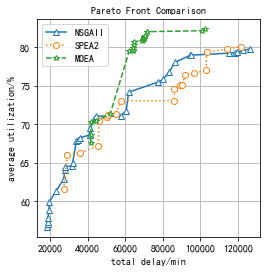

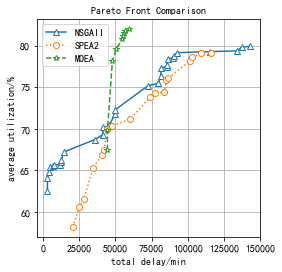

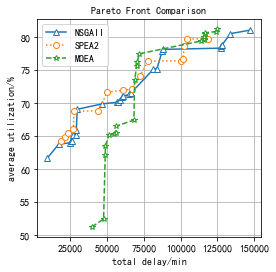

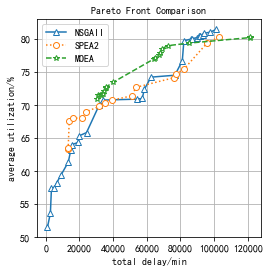

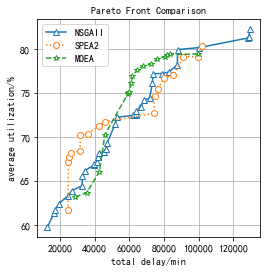

In [6]:
for timeindex in range(1,6):
    road = "E:\\JavaProjects\\scheduling_of_rfl\\result"
    path = "\\case2_time%d" % timeindex
    NSGAIITotalDelay, NSGAIIUtilization = readScatterData(road + path + "\\NSGAII_2\\ParetoFront.txt")
    SPEA2TotalDelay, SPEA2Utilization = readScatterData(road + path + "\\SPEA2_2\\ParetoFront.txt")
    MOEATotalDelay, MOEAUtilization = readScatterData(road + path + "\\MOEA\\ParetoFront.txt")
    NSGAIITotalDelay.sort()
    NSGAIIUtilization.sort()
    SPEA2TotalDelay.sort()
    SPEA2Utilization.sort()
    MOEATotalDelay.sort()
    MOEAUtilization.sort()
    fig = plt.figure(timeindex, figsize=(4,4))
    plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
    plt.plot(NSGAIITotalDelay, NSGAIIUtilization, marker='^', markersize='6', markerfacecolor='w', ls='-', label='NSGAII')
    plt.plot(SPEA2TotalDelay, SPEA2Utilization, marker='o', markersize='6', markerfacecolor='w', ls=':', label='SPEA2')
    plt.plot(MOEATotalDelay, MOEAUtilization, marker='*', markersize='6', markerfacecolor='w', ls='--', label='MOEA')
    plt.xlabel("total delay/min", fontdict={'size': 12}, fontproperties='SimHei')
    plt.ylabel("average utilization/%", fontdict={'size': 12}, fontproperties='SimHei')
    plt.title("Pareto Front Comparison", fontdict={'size': 14}, fontproperties='SimHei')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(road + path + "算法最优解比较图.png", format='png')
    print('NSGAII：\t%d个Pareto解' % len(NSGAIITotalDelay))
    print('SPEA2：\t%d个Pareto解' % len(SPEA2TotalDelay))
    print('MOEA：\t%d个Pareto解' % len(MOEATotalDelay))

    #%% 前沿面C-metric
    c = 0
    for i in range(len(NSGAIITotalDelay)):
        for j in range(len(SPEA2TotalDelay)):
            if NSGAIIUtilization[i] <= SPEA2Utilization[j] and NSGAIITotalDelay[i] > SPEA2TotalDelay[j] or NSGAIIUtilization[i] < SPEA2Utilization[j] and NSGAIITotalDelay[i] == SPEA2TotalDelay[j]:
                c+=1
                break
    c = c/len(NSGAIITotalDelay)
    print('C(SPEA2, NSGAII) = %f, ' % c, end=' ')
    c = 0
    for i in range(len(SPEA2Utilization)):
        for j in range(len(NSGAIITotalDelay)):
            if NSGAIIUtilization[j] >= SPEA2Utilization[i] and NSGAIITotalDelay[j] < SPEA2TotalDelay[i] or NSGAIIUtilization[j] > SPEA2Utilization[i] and NSGAIITotalDelay[j] == SPEA2TotalDelay[i]:
                c+=1
                break
    c = c/len(SPEA2Utilization)
    print('C(NSGAII, SPEA2) = %f; ' % c)

    c = 0
    for i in range(len(NSGAIITotalDelay)):
        for j in range(len(MOEATotalDelay)):
            if NSGAIIUtilization[i] <= MOEAUtilization[j] and NSGAIITotalDelay[i] > MOEATotalDelay[j] or NSGAIIUtilization[i] < MOEAUtilization[j] and NSGAIITotalDelay[i] == MOEATotalDelay[j]:
                c+=1
                break
    c = c/len(NSGAIITotalDelay)
    print('C(MOEA, NSGAII) = %f, ' % c, end=' ')
    c = 0
    for i in range(len(MOEAUtilization)):
        for j in range(len(NSGAIITotalDelay)):
            if NSGAIIUtilization[j] >= MOEAUtilization[i] and NSGAIITotalDelay[j] < MOEATotalDelay[i] or NSGAIIUtilization[j] > MOEAUtilization[i] and NSGAIITotalDelay[j] == MOEATotalDelay[i]:
                c+=1
                break
    c = c/len(MOEAUtilization)
    print('C(NSGAII, MOEA) = %f; ' % c)

    # %% 超体积指标HV
    r_TotalDelay, r_Utilization = (1500000, 40)
    NSGAIITotalDelay.insert(0, r_TotalDelay)
    SPEA2TotalDelay.insert(0, r_TotalDelay)
    MOEATotalDelay.insert(0, r_TotalDelay)
    NSGAIIUtilization.insert(0, r_Utilization)
    SPEA2Utilization.insert(0, r_Utilization)
    MOEAUtilization.insert(0, r_Utilization)
    HV = 0
    for i in range(1, len(NSGAIITotalDelay)):
        HV += (r_TotalDelay - NSGAIITotalDelay[i]) * (NSGAIIUtilization[i] - NSGAIIUtilization[i-1])
    print('HV(NSGAII) =\t%-f, ' % HV)
    HV = 0
    for i in range(1, len(SPEA2TotalDelay)):
        HV += (r_TotalDelay - SPEA2TotalDelay[i]) * (SPEA2Utilization[i] - SPEA2Utilization[i-1])
    print('HV(SPEA2) = \t%-f, ' % HV)
    HV = 0
    for i in range(1, len(MOEATotalDelay)):
        HV += (r_TotalDelay - MOEATotalDelay[i]) * (MOEAUtilization[i] - MOEAUtilization[i-1])
    print('HV(MOEA) =\t%-f. ' % HV)

In [8]:
# %% 画nsgaii迭代曲线图
p = "E:\\JavaProjects\\scheduling_of_rfl\\result\\8.31 with MOEA\\case1_time6\\SPEA2_2"
utilization = []
totaldelay = []
toptotaldelay = []
toputilization = []
bottomtotaldelay = []
bottomutilization = []


Text(0, 0.5, 'average utilization/%')

Text(0.5, 0, 'iteration')

Text(0, 0.5, 'total delay/min')

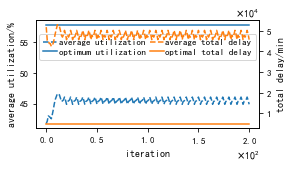

In [9]:

with open(p + "\\uOfA.txt") as f:
    for line in f.readlines():
        utilization.append(json.loads(line))
with open(p + "\\tOfA.txt") as f:
    for line in f.readlines():
        totaldelay.append(json.loads(line))
with open(p + "\\topuOfA.txt") as f:
    for line in f.readlines():
        toputilization.append(json.loads(line))
with open(p + "\\bottomtOfA.txt") as f:
    for line in f.readlines():
        bottomtotaldelay.append(json.loads(line))
with open(p + "\\bottomuOfA.txt") as f:
    for line in f.readlines():
        bottomutilization.append(json.loads(line))
with open(p + "\\toptOfA.txt") as f:
    for line in f.readlines():
        toptotaldelay.append(json.loads(line))
fig = plt.figure(2, figsize=(4,2))
# plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
# 绘制利用率
ax1 = fig.add_subplot(111)
line1 = ax1.plot(range(0,len(utilization)), utilization, color='C0', linestyle='--',label="average utilization")
line2 = ax1.plot(range(0,len(toputilization)), toputilization, color='C0', label="optimum utilization")
# line1 = ax1.plot(range(0,len(utilization)), utilization, color='grey', linestyle='--',label="average utilization")
# line2 = ax1.plot(range(0,len(toputilization)), toputilization, color='grey', label="optimum utilization")
# ax1.fill_between(range(0,len(toputilization)), toputilization, bottomutilization, color='C0', alpha=.3, linewidth=0)
ax1.set_ylabel('average utilization/%', fontsize=10)
ax1.set_xlabel('iteration', fontsize=10)
ax1.tick_params(labelsize=9)
# ax1.legend(loc='best', handletextpad=0.2, labelspacing=0.2, borderpad=0.5)
# 绘制延期时间
ax2 = ax1.twinx()
line3 = ax2.plot(range(0,len(totaldelay)), totaldelay, color='C1', linestyle='--', label="average total delay")
line4 = ax2.plot(range(0,len(bottomtotaldelay)), bottomtotaldelay, color='C1', label="optimal total delay")
# line3 = ax2.plot(range(0,len(totaldelay)), totaldelay, color='black', linestyle='--', label="average total delay")
# line4 = ax2.plot(range(0,len(bottomtotaldelay)), bottomtotaldelay, color='black', label="optimal total delay")
# ax2.fill_between(range(0,len(toptotaldelay)), toptotaldelay, bottomtotaldelay, color='C1', alpha=.3, linewidth=0)
ax2.set_ylabel('total delay/min', fontsize=10)
ax2.tick_params(labelsize=9)
plt.ticklabel_format(style='sci',scilimits=(0,0), axis='both', useMathText=True)
# 合并图例
lines = line1 + line2 + line3 + line4
labels = [l.get_label() for l in lines]
# ax2.legend(loc='best', handletextpad=0.2, labelspacing=0.2, borderpad=0.5)
ax1.legend(
    lines, labels, ncol=2,
    handlelength=1.5, handletextpad=0.2, labelspacing=0.2, borderpad=0.5, columnspacing=0.5, borderaxespad=1,
    fontsize=9, 
    loc='center', bbox_to_anchor=(0.5, 0.75)
)
# plt.title('迭代曲线图')
plt.savefig(p + "\\迭代曲线图.png", format='png')
plt.show()

Text(0.5, 0, '总拖期时间/min')

Text(0, 0.5, '平均设备利用率/%')

Text(0.5, 1.0, '算法解散点图')

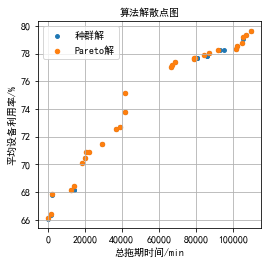

In [7]:
# %% 画散点图
p = ("E:\\JavaProjects\\configuration_and_scheduling_of_MRFL\\SPEA2\\sourse\\case3")
allTotalDelay, allUtilization = readAllScatterData(p + "\\archiveObj.txt")
TotalDelay, Utilization = readScatterData(p + "\\ParetoFront.txt")
# with open(p + "\\archiveObj.txt") as f:
#     lines = f.readlines()
#     line = lines[0]
#     scatterData = json.loads(line)
#     allTotalDelay, allUtilization = readScatterData(scatterData)
# with open(p + "\\ParetoFront.txt") as f:
#     lines = f.readlines()
#     line = lines[0]
#     scatterData = json.loads(line)
#     TotalDelay, Utilization = readScatterData(scatterData)
fig = plt.figure(1, figsize=(4,3.8))
plt.rcParams['font.sans-serif'] = ['SimHei'] #显示中文
plt.scatter(allTotalDelay, allUtilization, s=15, label='种群解')
plt.scatter(TotalDelay, Utilization, color='C1', s=20, label='Pareto解')
plt.xlabel("总拖期时间/min", fontdict={'size': 12}, fontproperties='SimHei')
plt.ylabel("平均设备利用率/%", fontdict={'size': 12}, fontproperties='SimHei')
plt.title("算法解散点图", fontdict={'size': 14}, fontproperties='SimHei')
plt.legend(loc='best')
plt.grid()
plt.savefig(p + "\\解散点图.png", format='png')

In [23]:
p = ("E:\\JavaProjects\\configuration_and_scheduling_of_MRFL\\SPEA2\\sourse\\case3")
allTotalDelay, allUtilization = readAllScatterData(p + "\\archiveObj.txt")
TotalDelay, Utilization = readScatterData(p + "\\ParetoFront.txt")
MINTotalDelay = min(TotalDelay)
MAXTotalDelay = max(TotalDelay)
MINUtilization = min(Utilization)
MAXUtilization = max(Utilization)
x = []
y = []
for i in range(len(TotalDelay)):
    x.append((TotalDelay[i] - MINTotalDelay)/(MAXTotalDelay - MINTotalDelay))
    y.append((Utilization[i] - MINUtilization)/(MAXUtilization - MINUtilization))
MINx = min(x)
MAXy = max(y)
gte = []
for i in range(len(TotalDelay)):
    gtey = abs(MAXy - y[i])
    gtex = abs(MINx - x[i])
    gtey,gtex
    gte.append(max(gtey,gtex))

(1.0, 0.0)

(0.8712199191815806, 0.019690063810391976)

(0.975572216745514, 0.017228805834092982)

(0.8497449006596485, 0.11536918869644484)

(0.8287880894387789, 0.13035551504102097)

(0.7037441420115715, 0.16603463992707385)

(0.6774776615176809, 0.18348222424794894)

(0.6476237925399373, 0.19019143117593437)

(0.646614263061394, 0.2024430264357338)

(0.6034027491166561, 0.2678760255241568)

(0.522197418089362, 0.33429352780309934)

(0.5129843972357869, 0.35686417502278944)

(0.33372431482998954, 0.3822971741112124)

(0.431099853032172, 0.37797629899726526)

(0.19439934813331583, 0.6048678213309024)

(0.18067653449892662, 0.6125250683682771)

(0.16638193696310488, 0.624102096627165)

(0.14886081878727164, 0.7177757520510483)

(0.1467383945940155, 0.7202370100273473)

(0.1428254174547371, 0.726982680036463)

(0.12931402866684794, 0.76718322698268)

(0.1164816020496422, 0.7923792160437557)

(0.10134158289754946, 0.8374658158614403)

(0.0816825903404318, 0.9318505013673656)

(0.0955742284735498, 0.9284776663628077)

(0.033002035024726206, 0.9594165907019143)

(0.06267111217394705, 0.9568094804010939)

(0.024356192516033603, 0.9745852324521422)

(0.0, 1.0)